In [1]:
import sys
import time
import os
from collections import defaultdict
import numpy as np
import jax.numpy as jnp
import vedo
from vedo import Volume, show
import vedo.plotter  # https://vedo.embl.es/docs/vedo/plotter.html#Plotter
from vedo.colors import color_map
vedo.settings.default_backend = "vtk"
# vedo.settings.renderer_frame_width = 1.
# vedo.settings.use_parallel_projection = True

import matplotlib.pyplot as plt
# from matplotlib import colormaps
# list(colormaps)
from matplotlib.colors import LinearSegmentedColormap

from ipywidgets import interact

from jax import jit, vmap, value_and_grad, nn
import jax
import jax.numpy as jnp
from jax.numpy.fft import fft2, ifft2, fftshift, fftfreq
from jaxdf import FourierSeries 
from jaxdf.operators import compose
from jwave.geometry import Domain, Medium, TimeAxis, circ_mask
from jwave.acoustics import simulate_wave_propagation

from v_system.VSystemGenerator import VSystemGenerator
import scipy.ndimage
import vis
import reconstruct as r
import generate_data as gd
import util as u
import reconstruct as r
from PADataset import PADataset
from flax import linen as nn

@u.timer
def reconstruct(func_recon, func_step, **kwargs):
    return func_recon(func_step=func_step, **kwargs)

key = jax.random.PRNGKey(68000)


dataset=PADataset()
data = dataset[0]
mu = data['mu']
c = data['c']
sensors = data['sensors']
ATT_masks = data['ATT_masks']
P_0 = data['P_0']
P_data = data['P_data']
angles = data['angles']
P_data_noisy = data['P_data_noisy']

save_path = '../../Report/figures/'
dpi = 1000
title_fontsize = 8

# Multiple illuminations

In [2]:
# Compute/Load reconstructions. Expect this to take a while and to fail. This script aggravates the fact that releasing GPU memory does not properly work in JAX. Restarting the kernel and running this cell again will pick up where it left off. With 12GB of VRAM, you can expect to reconstruct 50 illuminations of a 128x128 image with a restart. Be sure to delete the generated folder defined in recon_path if you want to start over.

# Parameters
# ----------------
file_index = 0
num_it = 26 # number of iterations used for reconstruction 
num_illums = [1, 2, 3, 4, 5, 20, 50] # the numbers of illuminations to reconstruct
num_its = np.array([184,150,122, 103, 87, 22, 9])*2 # the number of iterations used for each reconstruction
# num_illums = np.concatenate(
#     [np.arange(1, 15, 1, dtype=int), (np.arange(15, 30, 3, dtype=int)), [40, 50]]
# )
# ----------------
recon_path = os.path.join(u.DATA_PATH, f"illums_l{len(num_illums)}_i{num_it}")
mu_r_path = os.path.join(recon_path, "mu_r")
c_r_path = os.path.join(recon_path, "c_r")
os.makedirs(mu_r_path, exist_ok=True)
os.makedirs(c_r_path, exist_ok=True)

loss = defaultdict(dict)
mu_rs = []
c_rs = []

# Load or reconstruct
index = 0
if os.path.exists(recon_path + "/loss.npy"):
    loss = np.load(recon_path + "/loss.npy", allow_pickle=True).item()
    index = len(loss["mu"])//num_it
for i, num_illum in enumerate(num_illums[index:]):
    mu_r_file = u.file(os.path.join(recon_path, "mu_r"), i)
    c_r_file = u.file(os.path.join(recon_path, "c_r"), i)

    if os.path.exists(mu_r_file) and os.path.exists(c_r_file):
        mu_r = jnp.load(mu_r_file)
        mu_rs.append(mu_r)
        c_r = jnp.load(c_r_file)
        c_rs.append(c_r)
        continue

    key, subkey = jax.random.split(key)
    (loss_recon, recon), run_time = reconstruct(
        func_recon=r.recon_2opt_r,
        func_step=r.recon_step_full_r,
        file_index=file_index,
        lr=[1.0, 1.0],
        num_illum=num_illum,
        num_it=num_its[i],
        key=subkey,
        dataset=dataset,
        func_step_kwargs={"r_mu": 0, "r_c": 0},
    )

    loss[num_illum]['mu']=np.array(loss_recon["mu"]).reshape(-1)
    loss[num_illum]['c']=np.array(loss_recon["c"]).reshape(-1)
    loss[num_illum]['data']=np.array(loss_recon["data"]).reshape(-1)
    loss[num_illum]['sum_mu_c']=np.array(loss_recon["sum_mu_c"]).reshape(-1)
    loss[num_illum]['run_time']=run_time
    mu_rs.append(recon["mu_rs"][-1].squeeze())
    c_rs.append(recon["c_rs"][-1].squeeze())

    jnp.save(mu_r_file, mu_rs[i])
    jnp.save(c_r_file, c_rs[i])
    jnp.save(recon_path + "/loss.npy", loss)

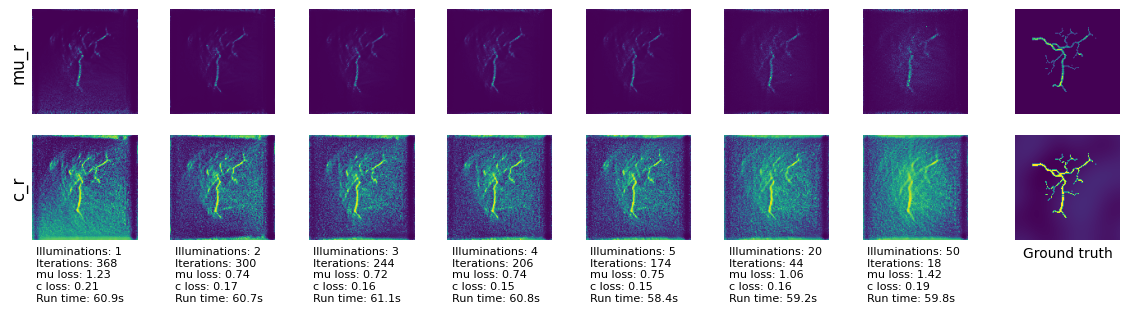

In [5]:
# Plot reconstructions with varying numbers of illuminations.

# Parameters
# ----------------
illums_to_plot = num_illums
# illums_to_plot = [1, 2, 3, 5, 50]
# ----------------

fig, ax = plt.subplots(2, len(illums_to_plot)+1, figsize=(14, 3.))
# fig.text(s=f"iterations: {num_it}", x=0.1, ha="left", y=.05)
# fig.text(0.135, 0.92, 'Illuminations →', va='center', ha='center', fontsize=8)

for i, num_illum in enumerate(illums_to_plot):
    ax[0][i].imshow(mu_rs[i], aspect="equal")
    ax[1][i].imshow(c_rs[i], aspect="equal")

    ax[0][i].axis("off")
    ax[1][i].axis("off")
    # ax[1][i].text(s=f"Illuminations: {num_illum} \nIterations: {num_its[i]}", x=5, y=135.,va='top', ha='left', fontsize=8)
    ax[1][i].text(fontsize=8,s=f"Illuminations: {num_illums[i]} \nIterations: {num_its[i]} \nmu loss: {loss[num_illums[i]]['mu'][-1]:.2f} \nc loss: {loss[num_illums[i]]['c'][-1]:.2f} \nRun time: {loss[num_illums[i]]['run_time']:.1f}s", x=5, y=135.,va='top', ha='left')
    # ax[0][i].set_xlabel(f"mu loss: {loss[num_illum]['mu'][-1]:.2f}\nRun time: {loss[num_illum]['run_time']:.2f}")
    # ax[1][i].set_xlabel(f"c loss: {loss[num_illum]['c'][-1]:.2f}\nRun time: {loss[num_illum]['run_time']:.2f}")

ax[0][0].text(-16, 64, 'mu_r', va='center', ha='center', rotation='vertical', fontsize=12)
ax[1][0].text(-16, 64, 'c_r', va='center', ha='center', rotation='vertical', fontsize=12)

i_gt = len(illums_to_plot)
im_mu_gt = ax[0][i_gt].imshow(mu, aspect="equal")
ax[1][i_gt].text(s=f"Ground truth", x=64, y=135.,va='top', ha='center')
# ax[0][i_gt].set_title("Ground Truth", fontsize=title_fontsize)
ax[0][i_gt].axis("off")
pos = ax[0][i_gt].get_position()
ax[0][i_gt].set_position([pos.x0 + 0.01, pos.y0, pos.width, pos.height])

# plt.colorbar(im_mu_gt, cax=ax[0][i_gt+1])
# ax[0][i_gt+1].tick_params(labelsize=7)  # Set the tick labels' font size
# ax[1][i_cb].yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
# pos = ax[0][i_gt+1].get_position()
# ax[0][i_gt+1].set_position([pos.x0 + 0.02, pos_im_r0.y0, pos.width, pos_im_r0.height])


im_c_gt = ax[1][i_gt].imshow(c, aspect="equal")
# ax[1][i_gt].set_title("Ground Truth", fontsize=title_fontsize)
ax[1][i_gt].axis("off")
pos = ax[1][i_gt].get_position()
ax[1][i_gt].set_position([pos.x0 + 0.01, pos.y0, pos.width, pos.height])

# plt.colorbar(im_c_gt, cax=ax[1][i_gt+1])
# ax[1][i_gt+1].tick_params(labelsize=7)  # Set the tick labels' font size
# pos = ax[1][i_gt+1].get_position()
# ax[1][i_gt+1].set_position([pos.x0 + 0.02, pos_im_r1.y0, pos.width, pos_im_r1.height])


plt.show()
fig.savefig(save_path + f"illum_recons_n{u.NOISE_AMPLITUDE}.pdf", format='pdf', dpi=dpi, bbox_inches='tight')   
# fig

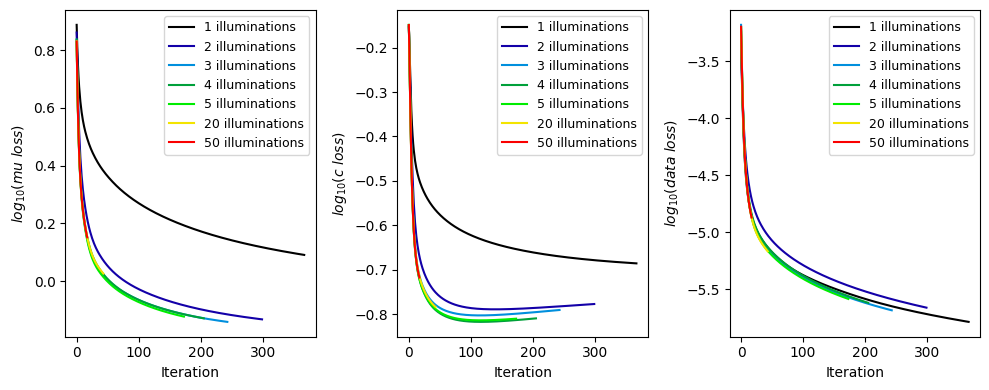

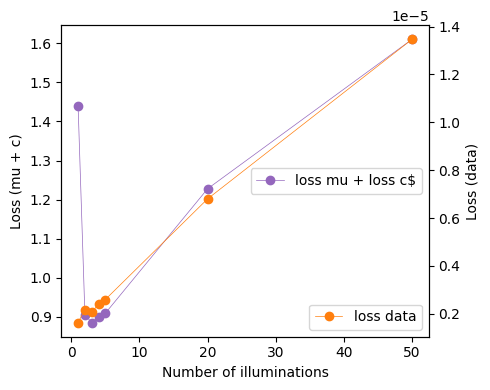

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


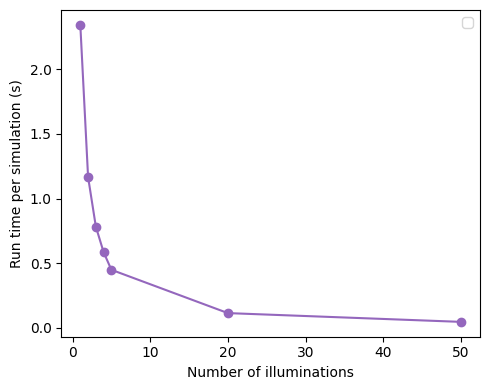

In [9]:
# Plot the losses of the reconstructions with varying numbers of illuminations.

# Parameters
# ----------------
# num_illums_to_plot = [1, 2, 3, 4, 5, 20, 50] # make sure the reconstructions above contain these illuminations
# num_illums_to_plot = [1, 2, 3, 4, 5, 21, 40, 50]
# ----------------

fig, ax = plt.subplots(1, 3, figsize=(10, 4))

cmap = plt.get_cmap('nipy_spectral', len(illums_to_plot)+1)
for i, num_illum in enumerate(illums_to_plot):
    ax[0].plot(jnp.log10(loss[num_illum]['mu']), label=f"{num_illum} illuminations", color=cmap(i), linestyle='-')
    ax[1].plot(jnp.log10(loss[num_illum]['c']), label=f"{num_illum} illuminations", color=cmap(i), linestyle='-')
    ax[2].plot(jnp.log10(loss[num_illum]['data']), label=f"{num_illum} illuminations", color=cmap(i), linestyle='-')

# Titles and labels for subplots
ax[0].set_ylabel(r"$log_{10}(mu\ loss)$")
ax[0].legend(fontsize=9, loc='upper right')
ax[0].set_xlabel("Iteration")

ax[1].set_ylabel(r"$log_{10}(c\ loss)$")
ax[1].legend(fontsize=9, loc='upper right')
ax[1].set_xlabel("Iteration")

ax[2].set_ylabel(r"$log_{10}(data\ loss)$")
ax[2].legend(fontsize=9, loc='upper right')
ax[2].set_xlabel("Iteration")
# ax[2].set_ylim(0.008, 0.02)

plt.tight_layout()
plt.show()

fig.savefig(save_path + f"illum_losses_vs_iteration_n{u.NOISE_AMPLITUDE}.pdf", format='pdf', dpi=dpi, bbox_inches='tight')  


# Plot Loss vs. Number of Illuminations
fig2, ax2 = plt.subplots(1, 1, figsize=(5, 4))
ax2.plot(num_illums, np.array([loss[num_illum]['sum_mu_c'][-1] for num_illum in num_illums], dtype=float), label="loss mu + loss c", color='tab:purple', marker='o', linestyle='-', linewidth=0.5)
                                # +np.array(loss[num_illum]['c'])[:, -1], label="mu", color='tab:red')
ax2.set_xlabel("Number of illuminations")
ax2.set_ylabel("Loss (mu + c)")
# ax2.set_title("Loss vs. number of illuminations")
ax2.legend(loc='center right')

# Plot corresponding 'c' loss on the same axis
# ax3 = ax2[3].twinx()
# ax3.plot(num_illums, np.array(loss['c'])[:, -1], label="c", color='tab:blue')
# ax3.set_ylabel("Loss (c)")
# ax3.legend(loc='upper center')

# Plot corresponding 'data' loss on the same axis
ax2_2 = ax2.twinx()
ax2_2.plot(num_illums, np.array([loss[num_illum]['data'][-1] for num_illum in num_illums]), label="loss data", color='tab:orange', marker='o', linestyle='-', linewidth=0.5) 
# ax2_2.spines['right'].set_position(('outward', 60))  # Shift the second twin y-axis to the right
ax2_2.set_ylabel("Loss (data)")
ax2_2.legend(loc='lower right')

plt.tight_layout()
plt.show()
fig2.savefig(save_path + f"illum_losses_vs_num_illums_n{u.NOISE_AMPLITUDE}.pdf", format='pdf', dpi=dpi, bbox_inches='tight')


# Plot run time
fig3, ax3 = plt.subplots(1, 1, figsize=(5, 4))
# ax3.plot(num_illums, np.array([loss[num_illum]['run_time']for num_illum in num_illums]) , label="run time", color='tab:green')
# ax3.set_title("Run time")
ax3.set_xlabel("Number of illuminations")
# ax3.set_ylabel("Run time")

# ax3_2 = ax3.twinx()
ax3.plot(num_illums, np.array([loss[num_illum]['run_time'] for num_illum in num_illums])/(jnp.multiply(jnp.array(num_illums),num_it)), color='tab:purple', marker='o') #label=r"$\frac{run\ time}{simulation}$")
# ax3.plot(num_illums, np.array([loss[num_illum]['data'][-1] for num_illum in num_illums])/np.array([loss[num_illum]['sum_mu_c'][-1] for num_illum in num_illums]), label="run time per loss", color='tab:purple')
ax3.set_ylabel("Run time per simulation (s)")
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()
fig3.savefig(save_path + f"illum_run_time_n{u.NOISE_AMPLITUDE}.pdf", format='pdf', dpi=dpi, bbox_inches='tight')


---

In [24]:
# num_its = [184,150,122, 103, 87, 22, 9]
# key = jax.random.split(key)
# for i, num_it in enumerate(num_its):
key, subkey = jax.random.split(key)
(loss_recon, recon), run_time = reconstruct(
func_recon=r.recon_2opt_r,
func_step=r.recon_step_full_r,
file_index=file_index,
lr=[1.0, 1.0],
num_illum=5,
num_it=81,
key=subkey,
dataset=dataset,
func_step_kwargs={"r_mu": 0, "r_c": 0},
)

illumination angles: [  0.        86.399994 172.79999  259.19998  352.8     ]
Finished 'reconstruct' in 27.8480 secs


# Work in progress

---

# View attenuation masks 

In [ ]:
# Troubleshooting attenuation mask generation
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import generate_data as gd
import util as u
N = u.N[:2]
from ipywidgets import interact, FloatText
plt.close('all')
def update(angle):
    dx=.1e-3
    attenuation = 300
    volume = jnp.ones(N)
    angle_rad = jnp.deg2rad(angle)
    ux = jnp.cos(angle_rad)
    uy = jnp.sin(angle_rad)
    height, width = volume.shape
    x_indices = jnp.arange(width)
    y_indices = jnp.arange(height)
    X, Y = jnp.meshgrid(x_indices, y_indices, indexing="ij")
    r = N[0]-u.TISSUE_MARGIN[0]
    center = np.min((width, height))//2
    X = X - width//2 + r * ux
    Y = Y - height//2 + r * uy
    distances = ux * X * dx + uy * Y * dx
    mask = jnp.exp(-attenuation * distances)
    result = jnp.clip(mask * volume, max=1.)
    # result = mask/jnp.max(mask) * volume
    return result, distances[0,0]

plt.draw()
mask, d0 = update(0)

center = np.array(mask.shape)//2
print(center)
print(mask[*center])
a = mask[*center]
ft = FloatText(a)

ftd = FloatText(d0)

im = plt.imshow(mask)
plt.colorbar(im)

display(ft)

@interact(angle=(0, 360, 1))
def plot(angle=0):
    mask, d0= update(angle)
    im.set_data(mask)
    im.set_clim(jnp.min(mask), jnp.max(mask))
    ft.value = mask[*center]
    ftd.value = d0

The following kwargs were not used by contour: 'aspect'


(0.0, 127.0, 0.0, 127.0)

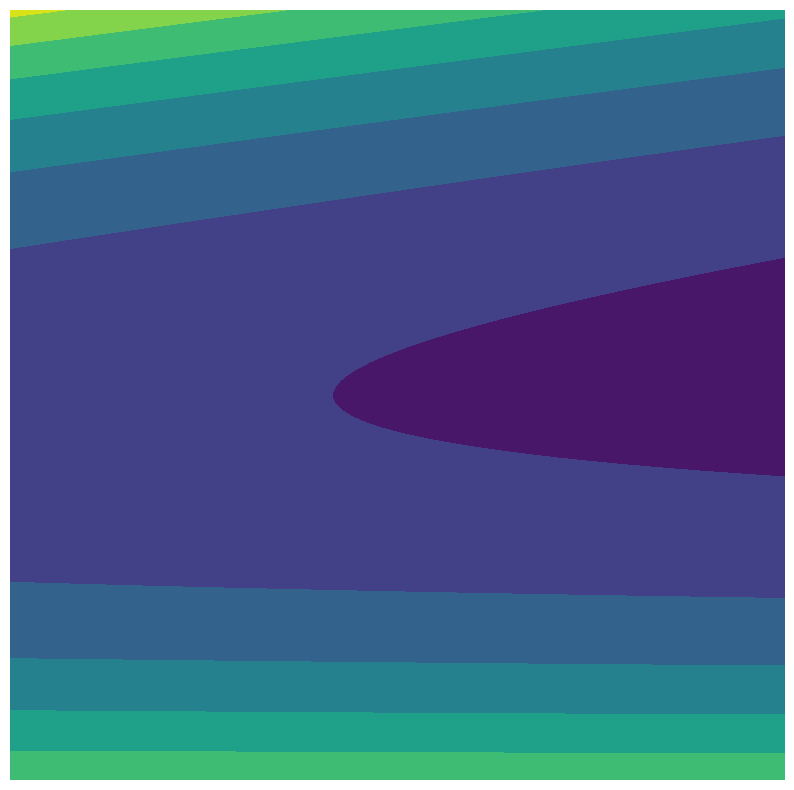

In [10]:
# Visualize patterns resulting from limited attenuation mask generation. Radial asymmetry may result in peaks in measured performance of reconstructions using specific illumination counts because they are selected from a radially non-symmetric generated set (Usually 50). Ideally, this should be maximally symmetric. Achieving this requires a restructuring of generate_data and PADataset.
   

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
num_angles = 50
num_illum = 2
illum_indices = np.linspace(0, num_angles-1, num_illum, endpoint=False).astype(int)

sum = jnp.sum(ATT_masks[illum_indices], axis=0).squeeze()
# for i in range(len(ATT_masks)):

ax.contourf(sum, aspect='equal')
ax.axis('off')

# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# for i in range(len(ATT_masks)):
#     ax.contour(ATT_masks[i].squeeze(), aspect='equal')
#     ax.axis('off')


In [48]:
angles

array([  0.      ,   7.2     ,  14.4     ,  21.599998,  28.8     ,
        36.      ,  43.199997,  50.399998,  57.6     ,  64.799995,
        72.      ,  79.2     ,  86.399994,  93.6     , 100.799995,
       108.      , 115.2     , 122.399994, 129.59999 , 136.8     ,
       144.      , 151.2     , 158.4     , 165.59999 , 172.79999 ,
       180.      , 187.2     , 194.4     , 201.59999 , 208.79999 ,
       216.      , 223.2     , 230.4     , 237.59999 , 244.79999 ,
       252.      , 259.19998 , 266.4     , 273.6     , 280.8     ,
       288.      , 295.19998 , 302.4     , 309.6     , 316.8     ,
       324.      , 331.19998 , 338.4     , 345.59998 , 352.8     ],
      dtype=float32)

In [49]:
angles[illum_indices]

array([  0.      ,  86.399994, 172.79999 , 259.19998 ], dtype=float32)

## Optimizing number of illuminations

In [ ]:
def loss_fn(num_illum_angles, num_it):
    num_illum_angles = jnp.int32(num_illum_angles)
    num_it = jnp.int32(num_it)
    (loss_data, recon), run_time = reconstruct_2(r.recon_step_ATr_2, lr=[1.,1.], num_illum=num_illum_angles, num_it=num_it) 
    return run_time / (loss_data['data'][0]-loss_data['data'][-1])


def finite_difference_gradients(loss_fn, num_illum_angles, num_it, epsilon=1e-2):
    # Compute the central difference approximation for gradients
    loss_original = loss_fn(num_illum_angles, num_it)
    # EPSILON MUST BE CHANGED
    loss_plus_illum = loss_fn(num_illum_angles + epsilon, num_it)
    d_num_illum_angles = (loss_plus_illum - loss_original) / epsilon
    
    loss_plus_it = loss_fn(num_illum_angles, num_it + epsilon)
    d_num_it = (loss_plus_it - loss_original) / epsilon
    
    return d_num_illum_angles, d_num_it

for i in range(4):

    print(f"\nnum_illum_angles: {num_illum_angles}, num_it: {num_it}")

    d_num_illum_angles, d_num_it = finite_difference_gradients(loss_fn, num_illum_angles, num_it)
    loss = loss_fn(num_illum_angles, num_it)
    print(f"d_num_illum_angles: {d_num_illum_angles}, d_num_it: {d_num_it}")
    print(f"Time per unit loss reduction: {loss:.2f} s")
    
    num_illum_angles -= d_num_illum_angles
    num_it -= d_num_it
    
    num_illum_angles = max(1, min(num_illum_angles, 50))
    num_it = max(1, min(num_it, 100))
